# Analysis of TRPO

## General setting:
* Policy mean: 64x64 tanh with biases
* Policy std: one logstd parameter for each action dimension
* Available random seeds: 324, 640, 454, 27, 496
* Batch size: 100
* delta = 0.2

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts

plt.close('all')

delta = 0.2

def read_data(path):
    df = pd.read_csv(path + 'progress.csv')
    iterations = len(df)
    batch_size = df['EpLenMean']
    sigma_1 = []
    sigma_2 = []
    for i in range(iterations - 1):
        policy_params = np.load(path + 'weights_' + str(i) + '.npy')
        #iws = np.load(path + 'iws_' + str(i) + '.npy')
        sigma_1.append(np.exp(policy_params[-2]))
        sigma_2.append(np.exp(policy_params[-1]))
    df['Sigma1'] = sigma_1
    df['Sigma2'] = sigma_2
    return df

def plot_data(dfs, columns, bottom=-np.infty, top=np.infty, rng=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if type(dfs) is not list:
        dfs = [dfs]
    n_subplots = len(dfs)
    for i in range(n_subplots): 
        df = dfs[i]
        if rng is not None:
            df = df[rng]
        ax.set_xlabel('Iteration')
        x = range(len(df))
        for col in columns:
            y = np.clip(df[col], bottom, top)
            ax.plot(x, y, label=col)
        ax.legend()
    return fig

def plot_ci(mean, std, conf, n_runs):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(mean.index, mean)
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    ax.fill_between(mean.index, interval[0], interval[1], alpha=0.3)
    return fig

# Performance Analysis

### Performance (undiscounted) on Swimmer with 5 different random seeds

**Available data**

In [52]:
n_iter = min(len(df) for df in dfs)
n_runs = len(dfs)
print('Number of runs:', n_runs)
print('Number of iterations per run:', n_iter)

Number of runs: 5
Number of iterations per run: 500


In [53]:
print('Columns:', list(dfs[0]))

Columns: ['optimgain', 'EpRewMean', 'J_hat', 'DiscEpRewMean', 'Step_size', 'ev_tdlam_before', 'TimestepsSoFar', 'SampleRenyi2', 'EpThisIter', 'EpLenMean', 'entloss', 'meankl', 'surrgain', 'Var_J', 'TimeElapsed', 'EpisodesSoFar', 'entropy', 'OurBound', 'Sigma1', 'Sigma2']


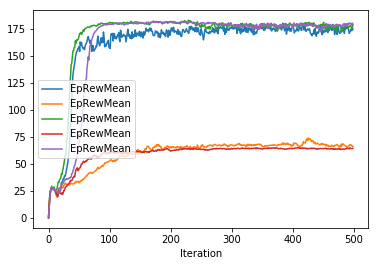

In [49]:
common_path = '../results/trpo/Swimmer/seed_'
seeds = [27, 324, 454, 496, 640]

dfs = []
for s in seeds:
    dfs.append(read_data(common_path + str(s) + '/'))
plot_data(dfs, ['EpRewMean'])

In [40]:
concat_df = pd.concat(dfs, axis=1)
mean_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).mean()
std_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).std()

Average performance with 95% confidence intervals:


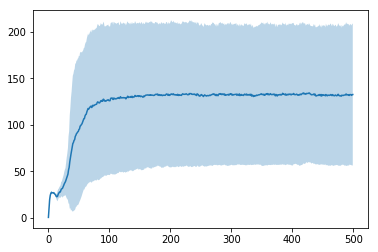

In [41]:
conf = 0.95
print('Average performance with %i%% confidence intervals:' % (conf*100))
mean = mean_df['EpRewMean']
std = std_df['EpRewMean']
plot_ci(mean, std, conf, n_runs)

### Std

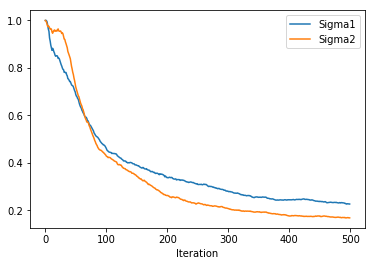

In [42]:
plot_data(mean_df, ['Sigma1', 'Sigma2'])

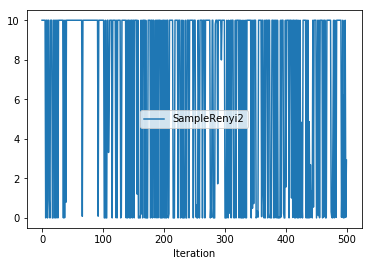

In [70]:
plot_data(dfs[4], ['SampleRenyi2'], top=10)